<a href="https://colab.research.google.com/github/ahiru60/Loan_Rejection_or_Approval_Status_Regression/blob/main/Loan_Rejection_or_Approval_Status_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from sklearn.metrics import accuracy_score

# **Data Understanding**

In [ ]:
# Load csv dataset
data = pd.read_csv("/content/loan_data_1.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            598 non-null    object 
 1   Gender             598 non-null    object 
 2   Married            598 non-null    object 
 3   Dependents         586 non-null    float64
 4   Education          598 non-null    object 
 5   Self_Employed      598 non-null    object 
 6   ApplicantIncome    598 non-null    int64  
 7   CoapplicantIncome  598 non-null    float64
 8   LoanAmount         577 non-null    float64
 9   Loan_Amount_Term   584 non-null    float64
 10  Credit_History     549 non-null    float64
 11  Property_Area      598 non-null    object 
 12  Loan_Status        598 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 60.9+ KB


In [ ]:
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents           float64
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
data.shape

(598, 13)

In [ ]:
# check for null data columns
data.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents           12
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           21
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
data['Loan_Amount_Term'].unique()

array([360., 120., 240.,  nan, 180.,  60., 300., 480.,  36.,  84.,  12.])

In [ ]:
# drop unwanted columns
#data = data.drop(['Loan_ID','Unnamed: 0'],axis=1)
data = data.drop(['Loan_ID','Unnamed: 0'],axis=1)

In [ ]:
data.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,586.000000,598.000000,598.000000,577.000000,584.000000,549.000000
mean,0.755973,5292.252508,1631.499866,144.968804,341.917808,0.843352
std,1.007751,5807.265364,2953.315785,82.704182,65.205994,0.363800
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.000000,1.000000
50%,0.000000,3806.000000,1211.500000,127.000000,360.000000,1.000000
75%,1.750000,5746.000000,2324.000000,167.000000,360.000000,1.000000
max,3.000000,81000.000000,41667.000000,650.000000,480.000000,1.000000


### **Data Processing**

In [ ]:
Original_data = data.copy()

In [ ]:
data['Dependents'] = data['Dependents'].replace('3+', '3')

In [ ]:
binary_categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed','Credit_History','Loan_Status']
non_binary_categorical_columns = ['Dependents', 'Property_Area']

In [ ]:
nonCategorical_columns = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with non binary categorical data
dependents_dummie = pd.get_dummies(data['Dependents'], prefix = 'Dependents')
property_Area_dummie = pd.get_dummies(data['Property_Area'], prefix = 'Property_Area')

# Remove categorical columns (will replace with one-hot encoding)
num_data = data.drop(non_binary_categorical_columns, axis=1)

# Add one-hot encoded columns to numerical features
OH_data = pd.concat([num_data, dependents_dummie,property_Area_dummie], axis=1)


# Ensure all columns have string type
OH_data.columns = OH_data.columns.astype(str)

OH_data.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0.0,Dependents_1.0,Dependents_2.0,Dependents_3.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,Male,No,Graduate,No,5849,0.0,NaN,360.0,1.0,Y,True,False,False,False,False,False,True
1,Male,Yes,Graduate,No,4583,1508.0,128.0,360.0,1.0,N,False,True,False,False,True,False,False
2,Male,Yes,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Y,True,False,False,False,False,False,True
3,Male,Yes,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Y,True,False,False,False,False,False,True
4,Male,No,Graduate,No,6000,0.0,141.0,360.0,1.0,Y,True,False,False,False,False,False,True


In [ ]:
# Transforming categorical data into numerical ordinal values
ordinal_encoder = OrdinalEncoder()
OH_data[binary_categorical_columns] = ordinal_encoder.fit_transform(OH_data[binary_categorical_columns])
OH_data.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0.0,Dependents_1.0,Dependents_2.0,Dependents_3.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1.0,0.0,0.0,0.0,5849,0.0,NaN,360.0,1.0,1.0,True,False,False,False,False,False,True
1,1.0,1.0,0.0,0.0,4583,1508.0,128.0,360.0,1.0,0.0,False,True,False,False,True,False,False
2,1.0,1.0,0.0,1.0,3000,0.0,66.0,360.0,1.0,1.0,True,False,False,False,False,False,True
3,1.0,1.0,1.0,0.0,2583,2358.0,120.0,360.0,1.0,1.0,True,False,False,False,False,False,True
4,1.0,0.0,0.0,0.0,6000,0.0,141.0,360.0,1.0,1.0,True,False,False,False,False,False,True


In [ ]:
data_plus = OH_data.copy()
cols_with_missing = [col for col in data.columns
                     if data[col].isnull().any()]


for col in cols_with_missing:
  data_plus[col + '_was_missing'] = data[col].isnull()

# imputing null data
my_imputer = SimpleImputer()
imputedData = pd.DataFrame(my_imputer.fit_transform(data_plus))
imputedData.columns = data_plus.columns
imputedData.head(50)
imputedData.isnull().sum()

Gender                          0
Married                         0
Education                       0
Self_Employed                   0
ApplicantIncome                 0
CoapplicantIncome               0
LoanAmount                      0
Loan_Amount_Term                0
Credit_History                  0
Loan_Status                     0
Dependents_0.0                  0
Dependents_1.0                  0
Dependents_2.0                  0
Dependents_3.0                  0
Property_Area_Rural             0
Property_Area_Semiurban         0
Property_Area_Urban             0
Dependents_was_missing          0
LoanAmount_was_missing          0
Loan_Amount_Term_was_missing    0
Credit_History_was_missing      0
dtype: int64

**Data Visualization**

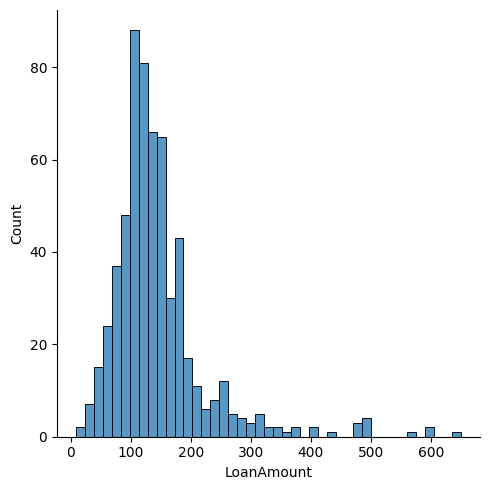

In [ ]:
sns.displot(imputedData["LoanAmount"])

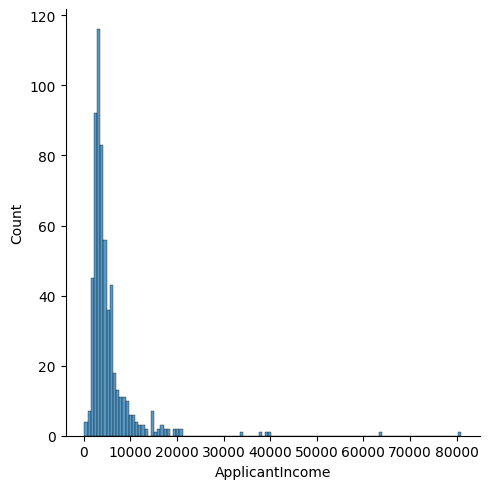

In [ ]:
sns.displot(imputedData["ApplicantIncome"])

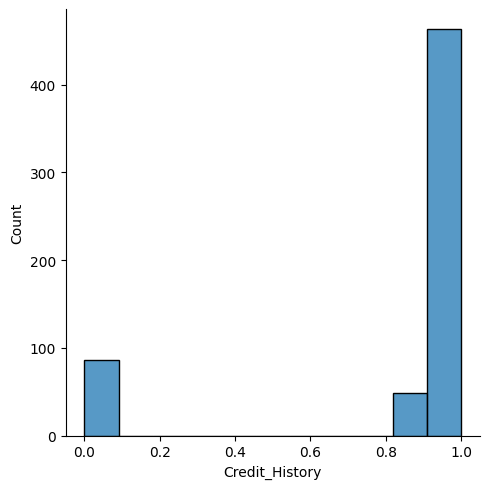

In [ ]:
sns.displot(imputedData["Credit_History"])

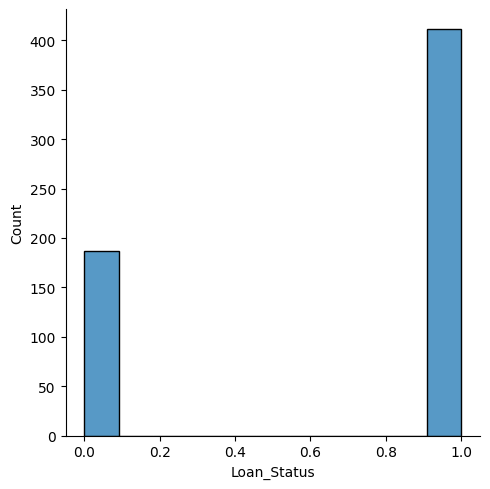

In [ ]:
sns.displot(imputedData["Loan_Status"])

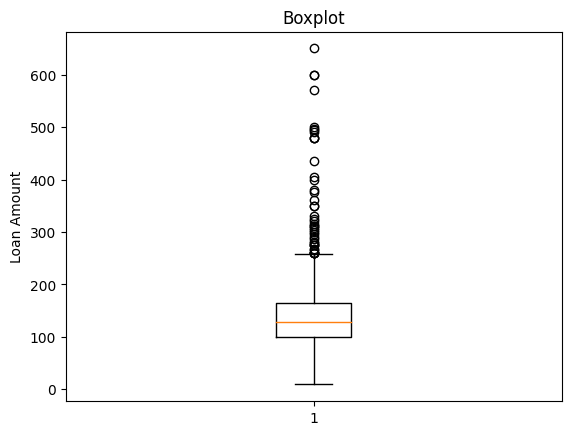

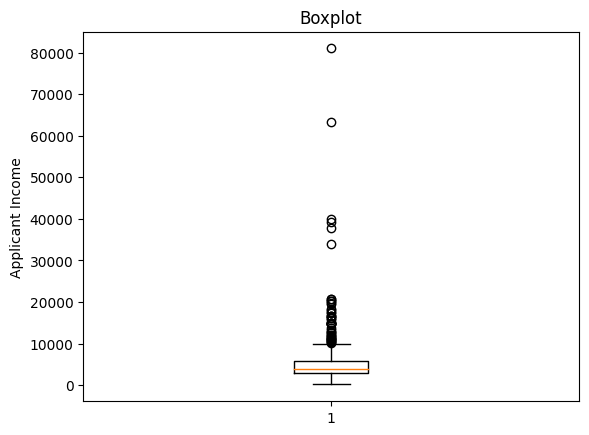

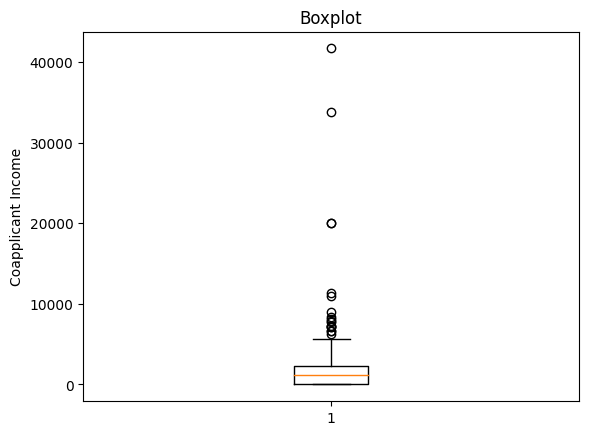

In [ ]:
plt.boxplot(imputedData['LoanAmount'])
plt.title('Boxplot')
plt.ylabel('Loan Amount')
plt.show()

plt.boxplot(imputedData['ApplicantIncome'])
plt.title('Boxplot')
plt.ylabel('Applicant Income')
plt.show()

plt.boxplot(imputedData['CoapplicantIncome'])
plt.title('Boxplot')
plt.ylabel('Coapplicant Income')
plt.show()

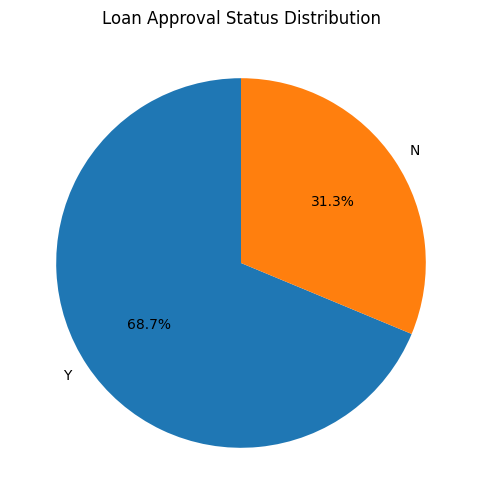

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(data['Loan_Status'].value_counts(), labels=Original_data['Loan_Status'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Loan Approval Status Distribution')
plt.show()

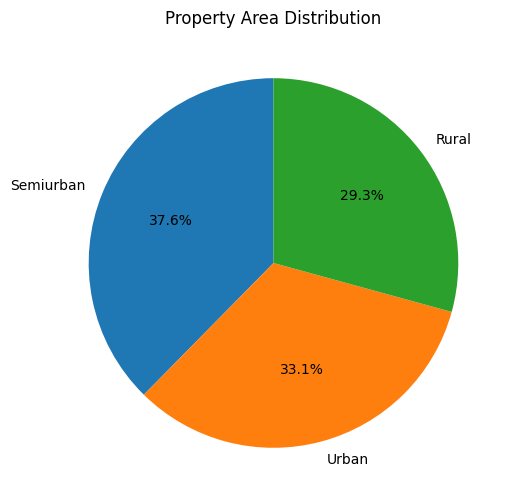

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(data['Property_Area'].value_counts(), labels=Original_data['Property_Area'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Property Area Distribution')
plt.show()

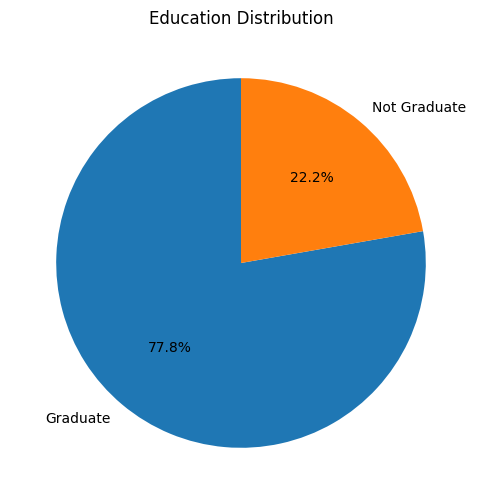

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(data['Education'].value_counts(), labels=Original_data['Education'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Education Distribution')
plt.show()

# **Data** **Mining**

In [ ]:
# calculating and visualizing correlation of each feature with the target value
corr_matrix = imputedData.corr()
corr_with_target = corr_matrix['Loan_Status'].sort_values(ascending=False)
print(corr_with_target)

Loan_Status                     1.000000
Credit_History                  0.535930
Property_Area_Semiurban         0.136702
Married                         0.093183
Dependents_2.0                  0.077234
Credit_History_was_missing      0.030548
Gender                          0.021239
Dependents_0.0                  0.012338
Self_Employed                  -0.005605
Loan_Amount_Term               -0.017305
ApplicantIncome                -0.025248
Loan_Amount_Term_was_missing   -0.038695
Dependents_3.0                 -0.039694
Dependents_1.0                 -0.042519
Property_Area_Urban            -0.046629
LoanAmount                     -0.054283
Dependents_was_missing         -0.057812
CoapplicantIncome              -0.058194
Education                      -0.081617
LoanAmount_was_missing         -0.086870
Property_Area_Rural            -0.097325
Name: Loan_Status, dtype: float64


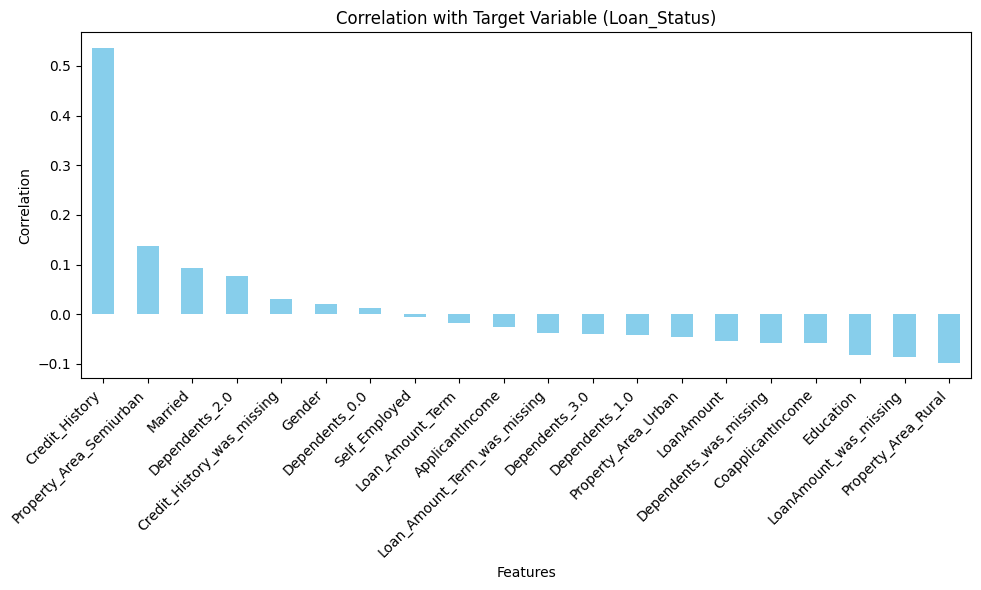

In [ ]:
plt.figure(figsize=(10, 6))
corr_with_target.drop('Loan_Status').plot(kind='bar', color='skyblue')
plt.title('Correlation with Target Variable (Loan_Status)')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
imputedData.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,...,Dependents_1.0,Dependents_2.0,Dependents_3.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Dependents_was_missing,LoanAmount_was_missing,Loan_Amount_Term_was_missing,Credit_History_was_missing
0,1.0,0.0,0.0,0.0,5849.0,0.0,144.968804,360.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,4583.0,1508.0,128.000000,360.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,3000.0,0.0,66.000000,360.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,2583.0,2358.0,120.000000,360.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,6000.0,0.0,141.000000,360.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#features = imputedData.columns.drop(['Loan_Status']).tolist()
features = imputedData.columns.drop(['ApplicantIncome','Loan_Status']).tolist()
#features = imputedData.columns.drop(['Loan_Status','Dependents_3+','ApplicantIncome','Self_Employed']).tolist()

y = imputedData['Loan_Status']
X = imputedData[features]

In [ ]:
imputedData['Loan_Amount_Term'].unique()

array([360.        , 120.        , 240.        , 341.91780822,
       180.        ,  60.        , 300.        , 480.        ,
        36.        ,  84.        ,  12.        ])

**Feature Scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardization
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(train_X)
# X_test_scaled = scaler.transform(val_X)

# Normalization
scaler = MinMaxScaler().set_output(transform="pandas")
X_normalized = scaler.fit_transform(X)

X_normalized.columns

Index(['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Dependents_0.0', 'Dependents_1.0', 'Dependents_2.0', 'Dependents_3.0',
       'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban',
       'Dependents_was_missing', 'LoanAmount_was_missing',
       'Loan_Amount_Term_was_missing', 'Credit_History_was_missing'],
      dtype='object')

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X_normalized, y, random_state = 10 ,test_size=0.3)

In [ ]:
loanPred_model = LogisticRegression()

loanPred_model.fit(train_X, train_y)

LogisticRegression()

# **Evaluation** **and** **Interpretation**

In [ ]:
val_predictions = loanPred_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

0.24166666666666667


In [ ]:
val_predictions

array([1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
       1.])

In [ ]:
# Validating using confusion metrix
conf_matrix = confusion_matrix(val_y, val_predictions.astype(int))
print("Confusion Matrix:")
print(conf_matrix)

# Extract True Positive, False Positive, True Negative, False Negative from the confusion matrix
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Compute accuracy, precision, recall, and F1 score
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Confusion Matrix:
[[17 26]
 [ 3 74]]
Accuracy: 0.7583333333333333
Precision: 0.74
Recall: 0.961038961038961
F1 Score: 0.8361581920903954


In [ ]:
print("accuracy score: ", round(accuracy_score(val_y, val_predictions) * 100, 2), "%")

accuracy score:  75.83 %


In [ ]:
joblib.dump(loanPred_model, 'Loan_Eligibility_Regressor.pkl')

['Loan_Eligibility_Regressor.pkl']